# Forest Fire Prediction Project - Data Integration & Feature Engineering

**Project**: Predicting Forest Fires using Soil and Climate Data  
**Study Area**: Algeria & Tunisia  
**Year**: 2024  

This notebook integrates all datasets into a unified feature space:
1. Create spatial grid covering the study area
2. Label fire/non-fire locations
3. Balance dataset through intelligent sampling
4. Extract climate features (monthly & seasonal)
5. Extract elevation data
6. Extract soil properties
7. Extract land cover information
8. Create final integrated dataset

In [1]:

## 0. Import Libraries and Configuration


import os
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.sample import sample_gen
from scipy.spatial import cKDTree
from scipy.interpolate import NearestNDInterpolator
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 8)


## 1. Load Base Datasets


In [2]:


# Loading fire occurrences and land boundaries.

def load_base_datasets():
    """Load fire data and land cover boundaries."""
    
    print("="*70)
    print("LOADING BASE DATASETS")
    print("="*70)
    
    # Load fire occurrences
    fires = pd.read_csv("../data/processed/Fire/combined_fire_data_2024.csv")

    print(f"Fire data loaded: {fires.shape[0]} occurrences")

    # only keep forest fires (type 0)
    fires = fires[fires['type'] == 0].reset_index(drop=True)
    print(f"Forest fire occurrences filtered: {fires.shape[0]} occurrences")
    
    # Load land boundaries
    land = gpd.read_file("../data/raw/Land Cover/combined/combined_landcover.shp").to_crs(4326)
    print(f"Land boundaries loaded: {land.shape[0]} features")
    
    print("="*70)
    
    return fires, land

fires, land = load_base_datasets()



# Display fire data summary
print("\nFire Data Summary:")
print(fires[['latitude', 'longitude', 'bright_ti4', 'frp']].describe())

LOADING BASE DATASETS
Fire data loaded: 90250 occurrences
Forest fire occurrences filtered: 14216 occurrences
Land boundaries loaded: 438513 features

Fire Data Summary:
           latitude     longitude    bright_ti4           frp
count  14216.000000  14216.000000  14216.000000  14216.000000
mean      31.679467      6.212258    325.973464      4.645305
std        2.851077      2.792512     19.397659      8.767106
min       19.603230     -8.118050    240.170000      0.060000
25%       30.221690      5.411770    307.535000      1.320000
50%       31.363310      6.511675    328.010000      2.660000
75%       32.528100      8.045517    341.750000      4.880000
max       37.323460     11.110350    367.000000    229.580000


## 2. Generate Spatial Grid


In [3]:


# Creating a regular grid over the study area for comprehensive spatial coverage.

def generate_spatial_grid(fires, land, grid_resolution=0.005):
    """
    Generate regular grid covering the study area.
    
    Parameters:
    -----------
    fires : DataFrame
        Fire occurrence data
    land : GeoDataFrame
        Land boundary polygons
    grid_resolution : float
        Grid cell size in degrees (0.005° ≈ 550m)
    
    Returns:
    --------
    grid_df : DataFrame
        Grid points within study area
    """
    
    print("="*70)
    print("GENERATING SPATIAL GRID")
    print("="*70)
    
    # Define grid extent with buffer
    lat_min = fires['latitude'].min() - grid_resolution
    lat_max = fires['latitude'].max() + grid_resolution
    lon_min = fires['longitude'].min() - grid_resolution
    lon_max = fires['longitude'].max() + grid_resolution
    
    print(f"Grid resolution: {grid_resolution}° (≈ {int(grid_resolution*111)}km)")
    print(f"Latitude range: [{lat_min:.4f}, {lat_max:.4f}]")
    print(f"Longitude range: [{lon_min:.4f}, {lon_max:.4f}]")
    
    # Generate grid points
    lats = np.arange(lat_min, lat_max, grid_resolution)
    lons = np.arange(lon_min, lon_max, grid_resolution)
    
    grid_points = [{'latitude': lat, 'longitude': lon} 
                   for lat in lats for lon in lons]
    
    print(f"Total grid points generated: {len(grid_points):,}")
    
    # Convert to GeoDataFrame
    grid_df = pd.DataFrame(grid_points)
    grid_gdf = gpd.GeoDataFrame(
        grid_df,
        geometry=gpd.points_from_xy(grid_df.longitude, grid_df.latitude),
        crs="EPSG:4326"
    )
    
    # Filter to points within land boundaries
    print("Filtering grid to land boundaries...")
    grid_gdf = gpd.sjoin(grid_gdf, land[['geometry']], how="inner", predicate="within")
    grid_gdf.drop(columns=["index_right"], inplace=True)
    
    grid_df = grid_gdf[['latitude', 'longitude']].copy()
    grid_df['fire'] = 0  # Initialize as non-fire
    
    print(f"✅ Grid points within study area: {len(grid_df):,}")
    print("="*70)
    
    return grid_df

# Generate grid
grid_df = generate_spatial_grid(fires, land, grid_resolution=0.005)


GENERATING SPATIAL GRID
Grid resolution: 0.005° (≈ 0km)
Latitude range: [19.5982, 37.3285]
Longitude range: [-8.1231, 11.1154]
Total grid points generated: 13,648,856
Filtering grid to land boundaries...
✅ Grid points within study area: 9,019,632


In [4]:

def combine_fires_with_background(grid_df, fires, tolerance=0.0025):
    """
    Combine actual fire instances with non-fire grid points.
    Grid points close to actual fires are removed to create a clean separation.
    
    Parameters:
    -----------
    grid_df : DataFrame
        Regular grid points (potential non-fire samples)
    fires : DataFrame
        Actual fire occurrences (positive samples)
    tolerance : float
        Radius to clear around fires (degrees). Grid points within this 
        distance of a fire are dropped.
    
    Returns:
    --------
    final_df : DataFrame
        Combined dataset containing all original fires and remaining grid points.
    """
    
    print("="*70)
    print("MERGING FIRES AND BACKGROUND GRID")
    print("="*70)
    
    # 1. Identify "contaminated" grid points (too close to fires)
    fire_coords = fires[['latitude', 'longitude']].values
    tree = cKDTree(fire_coords)
    
    # Query grid points against the fire tree
    # distance_upper_bound ensures we only care about neighbors within the tolerance
    distances, _ = tree.query(grid_df[['latitude', 'longitude']].values, 
                              distance_upper_bound=tolerance)
    
    # 2. Filter the Grid
    non_fire_grid = grid_df[distances == np.inf].copy()
    non_fire_grid['fire'] = 0
    
    print(f"Original grid points: {len(grid_df):,}")
    print(f"Grid points removed (overlap with fires): {len(grid_df) - len(non_fire_grid):,}")
    print(f"Clean background points kept: {len(non_fire_grid):,}")

    # 3. Prepare Fire Data
    actual_fires = fires[['latitude', 'longitude']].copy()
    actual_fires['fire'] = 1  # Explicitly label as fire
    
    print(f"Actual fire instances kept: {len(actual_fires):,}")
    
    # 4. Concatenate
    # -----------------------------------------------------------
    final_df = pd.concat([actual_fires, non_fire_grid], axis=0).reset_index(drop=True)
    
    n_fire = final_df['fire'].sum()
    n_nonfire = (final_df['fire'] == 0).sum()
    
    print("-" * 30)
    print(f"✅ Final Dataset Size: {len(final_df):,}")
    print(f"   - Fire samples: {n_fire:,}")
    print(f"   - Non-fire samples: {n_nonfire:,}")
    print(f"   - Imbalance Ratio: 1:{n_nonfire/n_fire:.1f}")
    print("="*70)
    
    return final_df


raw_grid = grid_df
final_dataset = combine_fires_with_background(raw_grid, fires, tolerance=0.0025)

MERGING FIRES AND BACKGROUND GRID
Original grid points: 9,019,632
Grid points removed (overlap with fires): 3,937
Clean background points kept: 9,015,695
Actual fire instances kept: 14,216
------------------------------
✅ Final Dataset Size: 9,029,911
   - Fire samples: 14,216
   - Non-fire samples: 9,015,695
   - Imbalance Ratio: 1:634.2


## 3. Label Fire and Non-Fire Locations

In [5]:
# Using spatial proximity to identify fire locations on the grid.

def label_fire_locations(grid_df, fires, tolerance=0.0025):
    """
    Label grid cells as fire/non-fire using KDTree for efficiency.
    
    Parameters:
    -----------
    grid_df : DataFrame
        Grid points
    fires : DataFrame
        Fire occurrences
    tolerance : float
        Distance threshold for fire labeling (degrees)
    
    Returns:
    --------
    grid_df : DataFrame
        Grid with fire labels
    """
    
    print("="*70)
    print("LABELING FIRE LOCATIONS")
    print("="*70)
    
    # Build KDTree for fast spatial queries
    fire_coords = fires[['latitude', 'longitude']].values
    tree = cKDTree(fire_coords)
    
    # Query distances to nearest fire
    distances, _ = tree.query(grid_df[['latitude', 'longitude']].values,
                              distance_upper_bound=tolerance)
    
    # Label fires
    grid_df.loc[distances < tolerance, 'fire'] = 1
    
    n_fire = grid_df['fire'].sum()
    n_nonfire = (grid_df['fire'] == 0).sum()
    
    print(f"✅ Fire cells: {n_fire:,}")
    print(f"✅ Non-fire cells: {n_nonfire:,}")
    print(f"Class imbalance ratio: 1:{int(n_nonfire/n_fire)}")
    print("="*70)
    
    return grid_df

# Label fire locations
grid_df = label_fire_locations(grid_df, fires)

LABELING FIRE LOCATIONS
✅ Fire cells: 3,937
✅ Non-fire cells: 9,015,695
Class imbalance ratio: 1:2289


In [6]:
# Add actual fire points to ensure coverage
fire_points = fires[['latitude', 'longitude']].copy()
fire_points['fire'] = 1

# Remove duplicates and combine
grid_df = grid_df[grid_df['fire'] == 0]  # Keep only non-fire from grid
grid_df = pd.concat([grid_df, fire_points], ignore_index=True)

print(f"\nFinal dataset size: {len(grid_df):,}")
print(f"Fire: {grid_df['fire'].sum():,}, Non-fire: {(grid_df['fire']==0).sum():,}")



Final dataset size: 9,029,911
Fire: 14,216, Non-fire: 9,015,695


## 4. Balance Dataset Through Sampling

In [7]:
# Implementing intelligent sampling strategies to handle class imbalance.

## 4.1 Sampling Strategy 1: Spatial Stratified Sampling
def spatial_stratified_sampling(grid_df, tile_size=0.05, frac=0.02):
    """
    Spatially stratified sampling of non-fire cells.
    Divides study area into tiles and samples within each.
    
    Parameters:
    -----------
    grid_df : DataFrame
        Grid with fire labels
    tile_size : float
        Size of spatial tiles (degrees)
    frac : float
        Fraction of non-fire cells to retain per tile
    
    Returns:
    --------
    sampled_df : DataFrame
        Balanced dataset
    """
    
    print("\n" + "="*70)
    print("SPATIAL STRATIFIED SAMPLING")
    print("="*70)
    
    df = grid_df.copy()
    
    # Separate fire and non-fire
    fire_df = df[df.fire == 1]
    nonfire_df = df[df.fire == 0]
    
    print(f"Original fire cells: {len(fire_df):,}")
    print(f"Original non-fire cells: {len(nonfire_df):,}")
    
    # Create spatial tiles
    nonfire_df["tile_lat"] = (nonfire_df.latitude // tile_size).astype(int)
    nonfire_df["tile_lon"] = (nonfire_df.longitude // tile_size).astype(int)
    
    n_tiles = nonfire_df.groupby(["tile_lat", "tile_lon"]).ngroups
    print(f"Spatial tiles created: {n_tiles}")
    
    # Sample within each tile
    sampled_list = []
    for (tlat, tlon), group in nonfire_df.groupby(["tile_lat", "tile_lon"]):
        sampled = group.sample(frac=frac, random_state=42)
        sampled_list.append(sampled)
    
    sampled_nonfire = pd.concat(sampled_list)
    sampled_nonfire.drop(columns=["tile_lat", "tile_lon"], inplace=True)
    
    # Combine with fire data
    sampled_df = pd.concat([fire_df, sampled_nonfire], ignore_index=True)
    
    print(f"Sampled non-fire cells: {len(sampled_nonfire):,}")
    print(f"Final dataset size: {len(sampled_df):,}")
    print(f"New class ratio: 1:{int(len(sampled_nonfire)/len(fire_df))}")
    print("="*70)
    
    return sampled_df

## 4.2 Sampling Strategy 2: Distance-Based Sampling
def distance_based_sampling(grid_df):
    """
    Distance-based sampling: retain more non-fire cells near fire locations.
    
    Parameters:
    -----------
    grid_df : DataFrame
        Grid with fire labels
    
    Returns:
    --------
    sampled_df : DataFrame
        Balanced dataset
    """
    
    print("\n" + "="*70)
    print("DISTANCE-BASED SAMPLING")
    print("="*70)
    
    df = grid_df.copy()
    
    fire_df = df[df.fire == 1]
    nonfire_df = df[df.fire == 0]
    
    # Compute distance to nearest fire
    fire_coords = fire_df[["latitude", "longitude"]].values
    tree = cKDTree(fire_coords)
    
    dists, _ = tree.query(nonfire_df[["latitude", "longitude"]].values)
    nonfire_df["dist"] = dists
    
    # Define distance bins and sampling rates
    bins = [0, 0.02, 0.05, 0.20, np.inf]
    fracs = [1.0, 0.4, 0.1, 0.01]  # Keep many near fires, few far away
    labels = ['Very Close', 'Close', 'Moderate', 'Far']
    
    nonfire_df["distance_bin"] = pd.cut(nonfire_df["dist"], bins=bins, labels=labels)
    
    print("Distance bins:")
    print(nonfire_df["distance_bin"].value_counts().sort_index())
    
    # Sample per bin
    sampled_list = []
    for label, frac in zip(labels, fracs):
        group = nonfire_df[nonfire_df.distance_bin == label]
        sampled = group.sample(frac=frac, random_state=42)
        sampled_list.append(sampled)
        print(f"  {label}: {len(group):,} → {len(sampled):,} (frac={frac})")
    
    sampled_nonfire = pd.concat(sampled_list)
    sampled_nonfire.drop(columns=["dist", "distance_bin"], inplace=True)
    
    sampled_df = pd.concat([fire_df, sampled_nonfire], ignore_index=True)
    
    print(f"\nFinal dataset size: {len(sampled_df):,}")
    print(f"Class ratio: 1:{int(len(sampled_nonfire)/len(fire_df))}")
    print("="*70)
    
    return sampled_df


## 4.3 Sampling Strategy 3: K-Means Environmental Clustering
def kmeans_environmental_sampling(grid_df, n_clusters=200, frac=0.1):
    """
    K-Means clustering followed by stratified sampling.
    Ensures diverse environmental representation.
    
    Parameters:
    -----------
    grid_df : DataFrame
        Grid with fire labels
    n_clusters : int
        Number of K-Means clusters
    frac : float
        Fraction to sample per cluster
    
    Returns:
    --------
    sampled_df : DataFrame
        Balanced dataset
    """
    
    print("\n" + "="*70)
    print("K-MEANS ENVIRONMENTAL SAMPLING")
    print("="*70)
    
    df = grid_df.copy()
    
    fire_df = df[df.fire == 1]
    nonfire_df = df[df.fire == 0]
    
    # Features for clustering (spatial coordinates)
    features = nonfire_df[["latitude", "longitude"]].values
    
    print(f"Clustering {len(nonfire_df):,} non-fire points into {n_clusters} clusters...")
    
    # K-Means clustering
    km = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=4096)
    labels = km.fit_predict(features)
    nonfire_df["cluster"] = labels
    
    print(f"Points per cluster: mean={len(nonfire_df)/n_clusters:.0f}")
    
    # Sample per cluster
    sampled_list = []
    for c, group in nonfire_df.groupby("cluster"):
        sampled = group.sample(frac=frac, random_state=42)
        sampled_list.append(sampled)
    
    sampled_nonfire = pd.concat(sampled_list)
    sampled_nonfire.drop(columns=["cluster"], inplace=True)
    
    sampled_df = pd.concat([fire_df, sampled_nonfire], ignore_index=True)
    
    print(f"Sampled non-fire cells: {len(sampled_nonfire):,}")
    print(f"Final dataset size: {len(sampled_df):,}")
    print(f"Class ratio: 1:{int(len(sampled_nonfire)/len(fire_df))}")
    print("="*70)
    
    return sampled_df

## 4.4 Adaptive grid sampling
def adaptive_grid_sampling(grid_df, base_tile=0.02):
    """
    Adaptive grid sampling: dynamically adjust sampling rates based on local density.
    Parameters:
    grid_df : DataFrame
    base_tile : float

    Returns:
    sampled_df : DataFrame
    """

    df = grid_df.copy()

    fire_df = df[df.fire == 1]
    nonfire_df = df[df.fire == 0]

    # Tile index
    nonfire_df["tile_lat"] = (nonfire_df.latitude // base_tile).astype(int)
    nonfire_df["tile_lon"] = (nonfire_df.longitude // base_tile).astype(int)

    sampled_list = []

    for (tlat, tlon), group in nonfire_df.groupby(["tile_lat", "tile_lon"]):
        size = len(group)

        # Dynamic sampling rate:
        if size < 200: frac = 1.0
        elif size < 800: frac = 0.5
        elif size < 3000: frac = 0.15
        else: frac = 0.03

        sampled = group.sample(
            frac=frac,
            random_state=42
        )
        sampled_list.append(sampled)

    sampled_nonfire = pd.concat(sampled_list)
    sampled_df = pd.concat([fire_df, sampled_nonfire], ignore_index=True)

    print("Adaptive Density Sampling")
    print("Original non-fire:", len(nonfire_df))
    print("Sampled non-fire:", len(sampled_nonfire))
    print("Final dataset:", len(sampled_df))

    return sampled_df


In [8]:
## 4.4 Apply Selected Sampling Strategy

# Choose sampling strategy (uncomment one)
grid_df = spatial_stratified_sampling(grid_df, tile_size=0.05, frac=0.01)
# grid_df = distance_based_sampling(grid_df)
# grid_df = kmeans_environmental_sampling(grid_df, n_clusters=200, frac=0.1)
# grid_df = adaptive_grid_sampling(grid_df, base_tile=0.02)

print(f"\nFinal class distribution:")
print(grid_df['fire'].value_counts())



SPATIAL STRATIFIED SAMPLING
Original fire cells: 14,216
Original non-fire cells: 9,015,695
Spatial tiles created: 91111
Sampled non-fire cells: 90,156
Final dataset size: 104,372
New class ratio: 1:6

Final class distribution:
fire
0    90156
1    14216
Name: count, dtype: int64


## 5. Extract Elevation Data

In [9]:

# Adding topographic information to each grid point.
def extract_elevation(grid_df, elev_path):
    """
    Extract elevation values at grid points.
    
    Parameters:
    -----------
    grid_df : DataFrame
        Grid points
    elev_path : str
        Path to elevation raster
    
    Returns:
    --------
    grid_df : DataFrame
        Grid with elevation values
    """
    
    print("="*70)
    print("EXTRACTING ELEVATION DATA")
    print("="*70)
    
    elev_src = rasterio.open(elev_path)
    
    print(f"Elevation raster CRS: {elev_src.crs}")
    print(f"Raster shape: {elev_src.shape}")
    
    # Sample elevation values
    coords = list(zip(grid_df.longitude, grid_df.latitude))
    elev_values = list(sample_gen(elev_src, coords))
    
    grid_df['elevation'] = [v[0] if v is not None else np.nan for v in elev_values]
    
    # Statistics
    print(f"\nElevation Statistics:")
    print(f"  Min: {grid_df['elevation'].min():.2f} m")
    print(f"  Max: {grid_df['elevation'].max():.2f} m")
    print(f"  Mean: {grid_df['elevation'].mean():.2f} m")
    print(f"  Missing: {grid_df['elevation'].isna().sum()}")
    
    print("Elevation extraction complete")
    print("="*70)
    
    return grid_df

# Extract elevation
elev_path = "../data/processed/Elevation/elevation_clipped.tif"
grid_df = extract_elevation(grid_df, elev_path)


EXTRACTING ELEVATION DATA
Elevation raster CRS: EPSG:4326
Raster shape: (4461, 4958)

Elevation Statistics:
  Min: -32768.00 m
  Max: 2475.00 m
  Mean: 501.43 m
  Missing: 0
Elevation extraction complete


## 6. Extract Climate Data

In [10]:

# Adding monthly and seasonal climate variables (temperature, precipitation).

def get_pixel_indices(src, lons, lats):
    """Get row, col indices for coordinates in raster."""
    rows, cols = rasterio.transform.rowcol(src.transform, lons, lats)
    return np.array(rows), np.array(cols)

def add_monthly_climate(df, folder, varname):
    """
    Extract monthly climate values for all grid points.
    
    Parameters:
    -----------
    df : DataFrame
        Grid points
    folder : str
        Path to climate rasters
    varname : str
        Variable name (tmax, tmin, prec)
    
    Returns:
    --------
    df : DataFrame
        Grid with monthly climate values
    """
    
    print(f"\nExtracting {varname.upper()}...")
    
    # Get sample file for coordinate mapping
    sample_file = f"wc2.1_cruts4.09_5m_{varname}_2024-01_clipped.tif"
    path_sample = os.path.join(folder, sample_file)
    
    if not os.path.exists(path_sample):
        print(f"⚠️  Warning: {sample_file} not found")
        return df
    
    with rasterio.open(path_sample) as src:
        height, width = src.shape
        rows, cols = get_pixel_indices(src, df.longitude.values, df.latitude.values)
        valid_idx = (rows >= 0) & (rows < height) & (cols >= 0) & (cols < width)
    
    # Extract for each month
    for m in range(1, 13):
        filename = f"wc2.1_cruts4.09_5m_{varname}_2024-{m:02d}_clipped.tif"
        path = os.path.join(folder, filename)
        
        if not os.path.exists(path):
            print(f"  ⚠️  Missing: {filename}")
            continue
        
        col_name = f"{varname}_{m:02d}"
        
        with rasterio.open(path) as src:
            arr = src.read(1)
            nodata_val = src.nodata
            
            extracted_values = np.full(len(df), np.nan)
            
            if valid_idx.any():
                raw_vals = arr[rows[valid_idx], cols[valid_idx]]
                if nodata_val is not None:
                    raw_vals = np.where(raw_vals == nodata_val, np.nan, raw_vals)
                extracted_values[valid_idx] = raw_vals
            
            df[col_name] = extracted_values
        
        print(f"  ✅ {col_name}")
    
    return df

def add_seasonal_climate(df, var):
    """
    Calculate seasonal averages from monthly data.
    
    Parameters:
    -----------
    df : DataFrame
        Grid with monthly climate
    var : str
        Variable name
    
    Returns:
    --------
    df : DataFrame
        Grid with seasonal climate
    """
    
    seasons = {
        "winter": ["12", "01", "02"],
        "spring": ["03", "04", "05"],
        "summer": ["06", "07", "08"],
        "fall":   ["09", "10", "11"]
    }
    
    available_cols = [c for c in df.columns if c.startswith(f"{var}_")]
    if not available_cols:
        return df
    
    for s, months in seasons.items():
        relevant_cols = [f"{var}_{m}" for m in months if f"{var}_{m}" in df.columns]
        if relevant_cols:
            df[f"{var}_{s}"] = df[relevant_cols].mean(axis=1)
    
    return df

def fill_missing_climate(df, climate_cols):
    """
    Fill missing climate values using nearest neighbor interpolation.
    
    Parameters:
    -----------
    df : DataFrame
        Grid with climate data
    climate_cols : list
        Climate column names
    
    Returns:
    --------
    df : DataFrame
        Grid with imputed climate values
    """
    
    print("\nFilling missing climate values...")
    
    coords = df[['latitude', 'longitude']].values
    
    for col in climate_cols:
        if col not in df.columns:
            continue
        
        mask_valid = ~df[col].isna()
        mask_missing = df[col].isna()
        
        if mask_missing.sum() == 0:
            continue
        
        if mask_valid.sum() == 0:
            print(f"  ⚠️  {col} is all NaN. Cannot fill.")
            continue
        
        print(f"  Filling {mask_missing.sum():,} values in {col}...")
        
        interp = NearestNDInterpolator(coords[mask_valid], df.loc[mask_valid, col])
        filled_vals = interp(coords[mask_missing])
        df.loc[mask_missing, col] = filled_vals
    
    print("✅ Missing value imputation complete")
    
    return df

# Extract climate data
print("="*70)
print("EXTRACTING CLIMATE DATA")
print("="*70)

climate_folder = "../data/processed/Climate"

grid_df = add_monthly_climate(grid_df, climate_folder, "tmax")
grid_df = add_monthly_climate(grid_df, climate_folder, "tmin")
grid_df = add_monthly_climate(grid_df, climate_folder, "prec")

# Calculate seasonal averages
print("\nCalculating seasonal averages...")
for var in ["tmax", "tmin", "prec"]:
    grid_df = add_seasonal_climate(grid_df, var)
    print(f"✅ {var} seasonal variables created")

# Drop monthly columns to reduce dimensionality
print("\nDropping monthly columns...")
for var in ["tmax", "tmin", "prec"]:
    cols_to_drop = [f"{var}_{m:02d}" for m in range(1, 13)]
    grid_df.drop(columns=[c for c in cols_to_drop if c in grid_df.columns], inplace=True)

# Fill missing values
climate_cols = [c for c in grid_df.columns if any(x in c for x in ['tmax', 'tmin', 'prec'])]
grid_df = fill_missing_climate(grid_df, climate_cols)

print("\n✅ Climate data extraction complete")
print("="*70)


EXTRACTING CLIMATE DATA

Extracting TMAX...
  ✅ tmax_01
  ✅ tmax_02
  ✅ tmax_03
  ✅ tmax_04
  ✅ tmax_05
  ✅ tmax_06
  ✅ tmax_07
  ✅ tmax_08
  ✅ tmax_09
  ✅ tmax_10
  ✅ tmax_11
  ✅ tmax_12

Extracting TMIN...
  ✅ tmin_01
  ✅ tmin_02
  ✅ tmin_03
  ✅ tmin_04
  ✅ tmin_05
  ✅ tmin_06
  ✅ tmin_07
  ✅ tmin_08
  ✅ tmin_09
  ✅ tmin_10
  ✅ tmin_11
  ✅ tmin_12

Extracting PREC...
  ✅ prec_01
  ✅ prec_02
  ✅ prec_03
  ✅ prec_04
  ✅ prec_05
  ✅ prec_06
  ✅ prec_07
  ✅ prec_08
  ✅ prec_09
  ✅ prec_10
  ✅ prec_11
  ✅ prec_12

Calculating seasonal averages...
✅ tmax seasonal variables created
✅ tmin seasonal variables created
✅ prec seasonal variables created

Dropping monthly columns...

Filling missing climate values...
  Filling 322 values in tmax_winter...
  Filling 322 values in tmax_spring...
  Filling 322 values in tmax_summer...
  Filling 322 values in tmax_fall...
  Filling 322 values in tmin_winter...
  Filling 322 values in tmin_spring...
  Filling 322 values in tmin_summer...
  Filling 322

## 7. Extract Soil Properties

In [11]:
# Adding soil characteristics from HWSD2 database.

def extract_soil_properties(grid_df):
    """
    Extract soil properties from raster and database.
    
    Parameters:
    -----------
    grid_df : DataFrame
        Grid points
    
    Returns:
    --------
    merged : DataFrame
        Grid with soil properties
    """
    
    print("="*70)
    print("EXTRACTING SOIL PROPERTIES")
    print("="*70)
    
    # Create GeoDataFrame
    grid_gdf = gpd.GeoDataFrame(
        grid_df,
        geometry=gpd.points_from_xy(grid_df.longitude, grid_df.latitude),
        crs="EPSG:4326"
    )
    
    # Open soil raster
    soil_raster = rasterio.open("../data/raw/Soil/HWSD2_RASTER/HWSD2.bil")
    print(f"Soil raster CRS: {soil_raster.crs}")
    
    # Reproject points
    points_proj = grid_gdf.to_crs(soil_raster.crs)
    coords = [(p.x, p.y) for p in points_proj.geometry]
    
    # Sample soil IDs
    print("Sampling soil IDs from raster...")
    soil_units = [int(v[0]) if v[0] != soil_raster.nodata else np.nan
                  for v in soil_raster.sample(coords)]
    grid_df["SOIL_ID"] = soil_units
    
    print(f"Unique soil types: {grid_df['SOIL_ID'].nunique()}")
    
    # Load soil attribute table
    print("Loading soil attributes from database...")
    conn = pyodbc.connect(
        "DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
        "DBQ=../data/raw/Soil/HWSD2_DB/HWSD2.mdb;"
    )
    
    soil_features = [
        "COARSE", "SAND", "SILT", "CLAY", "TEXTURE_USDA", "TEXTURE_SOTER",
        "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER", "TOTAL_N", "CN_RATIO",
        "CEC_SOIL", "CEC_CLAY", "CEC_EFF", "TEB", "BSAT", "ALUM_SAT", "ESP",
        "TCARBON_EQ", "GYPSUM", "ELEC_COND"
    ]
    
    query = f"""
    SELECT HWSD2_SMU_ID, {','.join(soil_features)}
    FROM HWSD2_LAYERS WHERE LAYER='D1'
    """
    
    soil_table = pd.read_sql(query, conn)
    conn.close()
    
    soil_table = soil_table.rename(columns={"HWSD2_SMU_ID": "SOIL_ID"})
    
    print(f"Soil table rows: {len(soil_table):,}")
    
    # Aggregate duplicates
    print("Aggregating duplicate soil IDs...")
    cat_cols = ['TEXTURE_USDA', 'TEXTURE_SOTER']
    num_cols = [c for c in soil_features if c not in cat_cols]
    
    agg_dict = {c: 'mean' for c in num_cols}
    agg_dict.update({c: 'first' for c in cat_cols})
    
    soil_table_unique = soil_table.groupby('SOIL_ID').agg(agg_dict).reset_index()
    
    print(f"Unique soil IDs after aggregation: {len(soil_table_unique):,}")
    
    # Merge
    print("Merging soil properties...")
    before_rows = len(grid_df)
    merged = grid_df.merge(soil_table_unique, how="left", on="SOIL_ID")
    after_rows = len(merged)
    
    if before_rows == after_rows:
        print("✅ Row count preserved")
    else:
        print(f"⚠️  Row count changed: {before_rows:,} → {after_rows:,}")
    
    print("✅ Soil property extraction complete")
    print("="*70)
    
    return merged

# Extract soil properties
grid_df = extract_soil_properties(grid_df)


EXTRACTING SOIL PROPERTIES
Soil raster CRS: OGC:CRS84
Sampling soil IDs from raster...
Unique soil types: 382
Loading soil attributes from database...
Soil table rows: 58,405
Aggregating duplicate soil IDs...
Unique soil IDs after aggregation: 29,538
Merging soil properties...
✅ Row count preserved
✅ Soil property extraction complete



## 8. Extract Land Cover Information

In [12]:

# Adding land cover type for each grid point.
def extract_landcover(grid_df):
    """
    Extract land cover type for grid points.
    
    Parameters:
    -----------
    grid_df : DataFrame
        Grid points
    
    Returns:
    --------
    joined : DataFrame
        Grid with land cover information
    """
    
    print("="*70)
    print("EXTRACTING LAND COVER")
    print("="*70)
    
    # Load land cover
    landcover = gpd.read_file("../data/raw/Land Cover/combined/combined_landcover.shp").to_crs(4326)
    print(f"Land cover polygons: {len(landcover):,}")
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        grid_df,
        geometry=gpd.points_from_xy(grid_df.longitude, grid_df.latitude),
        crs="EPSG:4326"
    )
    
    # Spatial join
    print("Performing spatial join...")
    joined = gpd.sjoin(gdf, landcover, how="left")
    joined.drop(columns=["index_right"], inplace=True, errors='ignore')
    
    print(f"✅ Land cover extracted for {(~joined['GRIDCODE'].isna()).sum():,} points")
    print("✅ Land cover extraction complete")
    print("="*70)
    
    return joined

# Extract land cover
grid_df = extract_landcover(grid_df)


EXTRACTING LAND COVER
Land cover polygons: 438,513
Performing spatial join...
✅ Land cover extracted for 104,365 points
✅ Land cover extraction complete


## 9. Data Quality Assessment

In [13]:
# Analyzing completeness and quality of the integrated dataset.
def assess_data_quality(df):
    """
    Assess and report data quality metrics.
    
    Parameters:
    -----------
    df : DataFrame
        Integrated dataset
    """
    
    print("="*70)
    print("DATA QUALITY ASSESSMENT")
    print("="*70)
    
    print(f"\n📊 Dataset Shape: {df.shape}")
    print(f"Total samples: {len(df):,}")
    print(f"Total features: {len(df.columns)}")
    
    print(f"\n🔥 Class Distribution:")
    print(df['fire'].value_counts())
    print(f"Class ratio: 1:{int((df['fire']==0).sum() / df['fire'].sum())}")
    
    print(f"\n📉 Missing Values Analysis:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Percentage': missing_pct
    }).sort_values('Percentage', ascending=False)
    
    print(missing_df[missing_df['Percentage'] > 0].head(20))
    
    print(f"\n✅ Features by Category:")
    feature_groups = {
        'Location': ['latitude', 'longitude'],
        'Target': ['fire'],
        'Elevation': ['elevation'],
        'Climate': [c for c in df.columns if any(x in c for x in ['tmax', 'tmin', 'prec'])],
        'Soil': [c for c in df.columns if c in ['SOIL_ID', 'COARSE', 'SAND', 'SILT', 'CLAY', 
                                                  'BULK', 'ORG_CARBON', 'PH_WATER', 'TOTAL_N', 
                                                  'CN_RATIO', 'CEC_SOIL', 'TEXTURE_USDA']],
        'Land Cover': [c for c in df.columns if 'GRIDCODE' in c or 'AREA' in c]
    }
    
    for group, cols in feature_groups.items():
        available = [c for c in cols if c in df.columns]
        print(f"  {group}: {len(available)} features")
    
    print("="*70)

# Assess data quality
assess_data_quality(grid_df)


DATA QUALITY ASSESSMENT

📊 Dataset Shape: (104372, 46)
Total samples: 104,372
Total features: 46

🔥 Class Distribution:
fire
0    90156
1    14216
Name: count, dtype: int64
Class ratio: 1:6

📉 Missing Values Analysis:
               Missing Count  Percentage
LCCCode_1              97519       93.43
AREA_M2                97519       93.43
TEXTURE_USDA           25243       24.19
REF_BULK               25243       24.19
LCCCODE                 6860        6.57
AREA                    6860        6.57
BSAT                       7        0.01
TOTAL_N                    7        0.01
CN_RATIO                   7        0.01
CEC_SOIL                   7        0.01
CEC_CLAY                   7        0.01
CEC_EFF                    7        0.01
TEB                        7        0.01
TCARBON_EQ                 7        0.01
ALUM_SAT                   7        0.01
ESP                        7        0.01
GYPSUM                     7        0.01
ELEC_COND                  7        0.01
TEX

## 10. Save Integrated Dataset

In [14]:

def save_integrated_dataset(df, output_path):
    """
    Save the integrated dataset to CSV.
    
    Parameters:
    -----------
    df : DataFrame
        Integrated dataset
    output_path : str
        Output file path
    """
    
    print("="*70)
    print("SAVING INTEGRATED DATASET")
    print("="*70)
    
    # Create output directory if needed
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    
    file_size = os.path.getsize(output_path) / (1024 * 1024)  # MB
    
    print(f"✅ Dataset saved to: {output_path}")
    print(f"File size: {file_size:.2f} MB")
    print(f"Rows: {len(df):,}")
    print(f"Columns: {len(df.columns)}")
    print("="*70)

# Save integrated dataset
output_path = "../data/processed/integrated_fire_dataset.csv"
save_integrated_dataset(grid_df, output_path)


SAVING INTEGRATED DATASET
✅ Dataset saved to: ../data/processed/integrated_fire_dataset.csv
File size: 51.17 MB
Rows: 104,372
Columns: 46


## 11. Visualize Integrated Dataset

CREATING VISUALIZATIONS


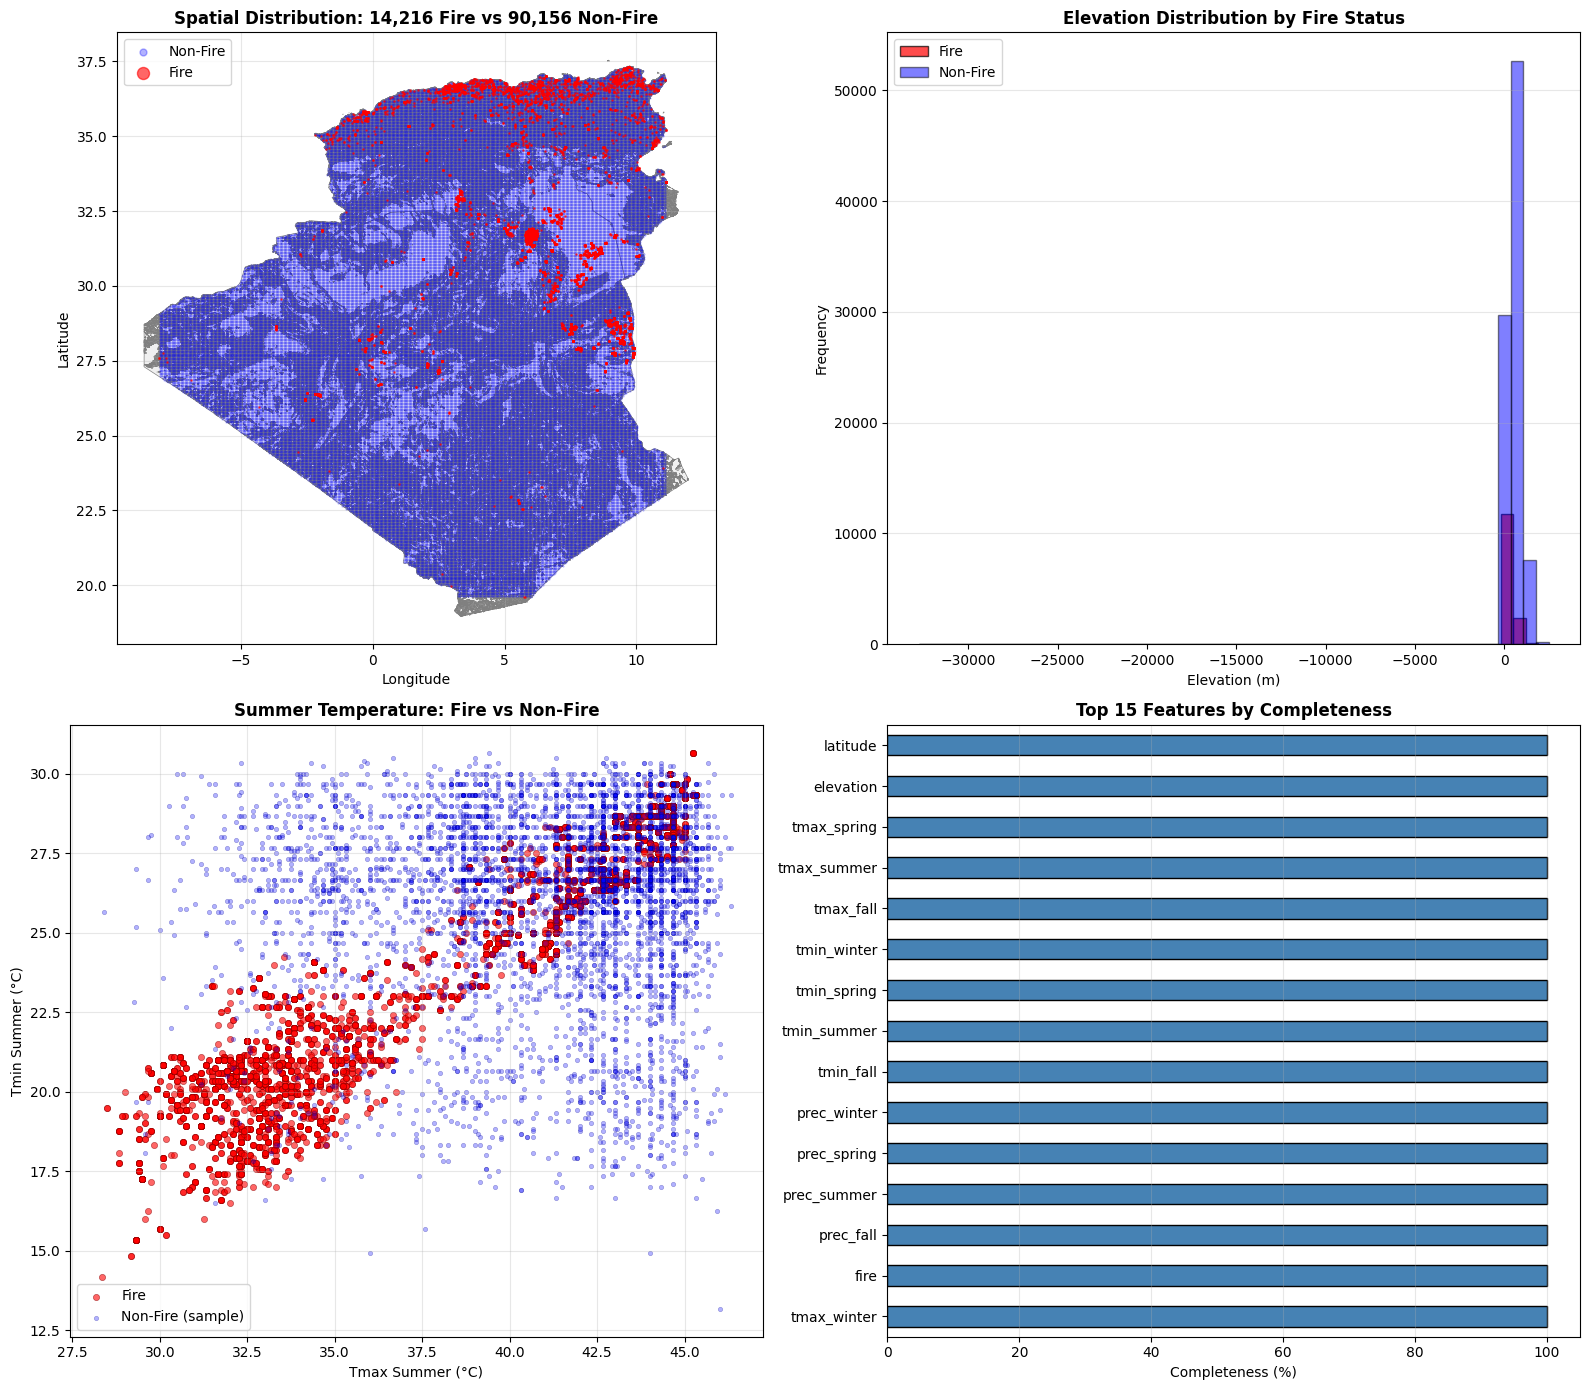

✅ Visualizations created


In [15]:

# Creating visualizations to understand the spatial distribution of fire and non-fire samples.
def visualize_integrated_data(df, land):
    """
    Create comprehensive visualizations of the integrated dataset.
    
    Parameters:
    -----------
    df : DataFrame
        Integrated dataset
    land : GeoDataFrame
        Land boundaries
    """
    
    print("="*70)
    print("CREATING VISUALIZATIONS")
    print("="*70)
    
    # Split into fire and non-fire
    fire_points = df[df['fire'] == 1]
    non_fire_points = df[df['fire'] == 0]
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Plot 1: Spatial Distribution
    ax1 = axes[0, 0]
    land.plot(ax=ax1, color='#f0f0f0', edgecolor='grey', linewidth=0.5, zorder=1)
    ax1.scatter(non_fire_points['longitude'], non_fire_points['latitude'], 
               c='blue', s=1, marker='.', alpha=0.3, label='Non-Fire', zorder=2, rasterized=True)
    ax1.scatter(fire_points['longitude'], fire_points['latitude'], 
               c='red', s=3, marker='.', alpha=0.6, label='Fire', zorder=3, rasterized=True)
    ax1.set_title(f'Spatial Distribution: {len(fire_points):,} Fire vs {len(non_fire_points):,} Non-Fire', 
                 fontsize=12, fontweight='bold')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.legend(markerscale=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Elevation Distribution
    ax2 = axes[0, 1]
    ax2.hist(fire_points['elevation'].dropna(), bins=50, alpha=0.7, 
            color='red', label='Fire', edgecolor='black')
    ax2.hist(non_fire_points['elevation'].dropna(), bins=50, alpha=0.5, 
            color='blue', label='Non-Fire', edgecolor='black')
    ax2.set_title('Elevation Distribution by Fire Status', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Elevation (m)')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # Plot 3: Climate Variables (Temperature)
    ax3 = axes[1, 0]
    if 'tmax_summer' in df.columns and 'tmin_summer' in df.columns:
        ax3.scatter(fire_points['tmax_summer'], fire_points['tmin_summer'], 
                   c='red', alpha=0.6, s=20, label='Fire', edgecolors='darkred', linewidth=0.5)
        ax3.scatter(non_fire_points['tmax_summer'].sample(min(5000, len(non_fire_points))), 
                   non_fire_points['tmin_summer'].sample(min(5000, len(non_fire_points))), 
                   c='blue', alpha=0.3, s=10, label='Non-Fire (sample)', edgecolors='darkblue', linewidth=0.5)
        ax3.set_title('Summer Temperature: Fire vs Non-Fire', fontsize=12, fontweight='bold')
        ax3.set_xlabel('Tmax Summer (°C)')
        ax3.set_ylabel('Tmin Summer (°C)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Feature Completeness
    ax4 = axes[1, 1]
    completeness = (1 - df.isnull().sum() / len(df)) * 100
    top_features = completeness.sort_values(ascending=True).tail(15)
    top_features.plot(kind='barh', ax=ax4, color='steelblue', edgecolor='black')
    ax4.set_title('Top 15 Features by Completeness', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Completeness (%)')
    ax4.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/integrated_dataset_overview.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualizations created")
    print("="*70)

# Create visualizations
visualize_integrated_data(grid_df, land)



## 12. Feature Summary Statistics

In [16]:

def generate_feature_statistics(df):
    """
    Generate comprehensive feature statistics.
    
    Parameters:
    -----------
    df : DataFrame
        Integrated dataset
    """
    
    print("="*70)
    print("FEATURE STATISTICS")
    print("="*70)
    
    # Separate by class
    fire_df = df[df['fire'] == 1]
    nonfire_df = df[df['fire'] == 0]
    
    # Select key numerical features
    key_features = ['elevation']
    
    # Add climate features if available
    climate_features = [c for c in df.columns if any(x in c for x in ['tmax', 'tmin', 'prec']) 
                       and any(s in c for s in ['summer', 'winter', 'spring', 'fall'])]
    key_features.extend(climate_features[:6])  # Top 6 climate features
    
    # Add soil features if available
    soil_features = [c for c in ['SAND', 'CLAY', 'SILT', 'ORG_CARBON', 'PH_WATER', 'BULK'] 
                    if c in df.columns]
    key_features.extend(soil_features)
    
    # Generate statistics
    print("\n📊 Fire vs Non-Fire Feature Comparison:\n")
    
    stats_comparison = []
    for feature in key_features:
        if feature not in df.columns:
            continue
        
        fire_mean = fire_df[feature].mean()
        nonfire_mean = nonfire_df[feature].mean()
        fire_std = fire_df[feature].std()
        nonfire_std = nonfire_df[feature].std()
        
        stats_comparison.append({
            'Feature': feature,
            'Fire Mean': f"{fire_mean:.2f}",
            'Fire Std': f"{fire_std:.2f}",
            'Non-Fire Mean': f"{nonfire_mean:.2f}",
            'Non-Fire Std': f"{nonfire_std:.2f}",
            'Difference': f"{abs(fire_mean - nonfire_mean):.2f}"
        })
    
    stats_df = pd.DataFrame(stats_comparison)
    print(stats_df.to_string(index=False))
    
    print("\n" + "="*70)

# Generate feature statistics
generate_feature_statistics(grid_df)


FEATURE STATISTICS

📊 Fire vs Non-Fire Feature Comparison:

    Feature Fire Mean Fire Std Non-Fire Mean Non-Fire Std Difference
  elevation    296.70   664.94        533.71       527.15     237.01
tmax_winter     19.53     2.51         21.14         3.73       1.61
tmax_spring     30.04     4.37         31.47         4.57       1.43
tmax_summer     41.29     4.47         40.95         3.54       0.34
  tmax_fall     31.26     3.40         31.80         3.72       0.54
tmin_winter      6.29     1.27          6.74         2.15       0.45
tmin_spring     15.59     2.64         16.39         3.37       0.80
       SAND     34.90    26.23         37.71        24.64       2.81
       CLAY     11.93    11.69         10.99         9.77       0.95
       SILT     19.61    15.75         18.47        14.06       1.15
 ORG_CARBON     -0.62     2.38         -0.56         1.91       0.06
   PH_WATER      4.13     5.35          4.37         4.77       0.23
       BULK     -0.24     2.57         -0.0


## 13. Data Integration Summary

In [17]:

def generate_integration_summary(df):
    """
    Generate comprehensive summary of data integration process.
    """
    
    print("\n" + "="*70)
    print("DATA INTEGRATION SUMMARY")
    print("="*70)
    
    print("\n✅ INTEGRATION COMPLETE")
    print("\n📊 Final Dataset Characteristics:")
    print(f"  • Total Samples: {len(df):,}")
    print(f"  • Fire Samples: {df['fire'].sum():,}")
    print(f"  • Non-Fire Samples: {(df['fire']==0).sum():,}")
    print(f"  • Total Features: {len(df.columns)}")
    print(f"  • Class Ratio: 1:{int((df['fire']==0).sum() / df['fire'].sum())}")
    
    print("\n🗂️  Integrated Data Sources:")
    print("  ✅ Fire Occurrences (VIIRS NOAA-20)")
    print("  ✅ Elevation (GMTED)")
    print("  ✅ Climate (WorldClim - Temperature & Precipitation)")
    print("  ✅ Soil Properties (HWSD2 - 22 attributes)")
    print("  ✅ Land Cover (FAO)")
    
    print("\n📈 Feature Categories:")
    feature_counts = {
        'Spatial': 2,
        'Elevation': 1,
        'Climate (Seasonal)': len([c for c in df.columns if any(x in c for x in ['tmax', 'tmin', 'prec'])]),
        'Soil': len([c for c in df.columns if c.upper() in ['SAND', 'SILT', 'CLAY', 'COARSE', 'BULK', 
                                                              'ORG_CARBON', 'PH_WATER', 'TOTAL_N', 'CN_RATIO',
                                                              'CEC_SOIL', 'CEC_CLAY', 'CEC_EFF']]),
        'Land Cover': len([c for c in df.columns if 'GRIDCODE' in c or 'AREA' in c])
    }
    
    for category, count in feature_counts.items():
        print(f"  • {category}: {count} features")
    
    print("\n💾 Output Files:")
    print("  • ../data/processed/integrated_fire_dataset.csv")
    print("  • ../outputs/integrated_dataset_overview.png")
    
    print("\n➡️  Next Steps:")
    print("  1. Feature engineering and transformation")
    print("  2. Handle remaining missing values")
    print("  3. Feature scaling and normalization")
    print("  4. Feature selection")
    print("  5. Model development (KNN, Decision Trees, Random Forest)")
    print("  6. Clustering analysis (K-Means, DBSCAN, CLARANS)")
    
    print("\n" + "="*70)
    print("🎉 DATA INTEGRATION PIPELINE COMPLETE")
    print("="*70 + "\n")

# Generate integration summary
generate_integration_summary(grid_df)



DATA INTEGRATION SUMMARY

✅ INTEGRATION COMPLETE

📊 Final Dataset Characteristics:
  • Total Samples: 104,372
  • Fire Samples: 14,216
  • Non-Fire Samples: 90,156
  • Total Features: 46
  • Class Ratio: 1:6

🗂️  Integrated Data Sources:
  ✅ Fire Occurrences (VIIRS NOAA-20)
  ✅ Elevation (GMTED)
  ✅ Climate (WorldClim - Temperature & Precipitation)
  ✅ Soil Properties (HWSD2 - 22 attributes)
  ✅ Land Cover (FAO)

📈 Feature Categories:
  • Spatial: 2 features
  • Elevation: 1 features
  • Climate (Seasonal): 12 features
  • Soil: 12 features
  • Land Cover: 3 features

💾 Output Files:
  • ../data/processed/integrated_fire_dataset.csv
  • ../outputs/integrated_dataset_overview.png

➡️  Next Steps:
  1. Feature engineering and transformation
  2. Handle remaining missing values
  3. Feature scaling and normalization
  4. Feature selection
  5. Model development (KNN, Decision Trees, Random Forest)
  6. Clustering analysis (K-Means, DBSCAN, CLARANS)

🎉 DATA INTEGRATION PIPELINE COMPLETE



## 14. Additional Diagnostic Plots

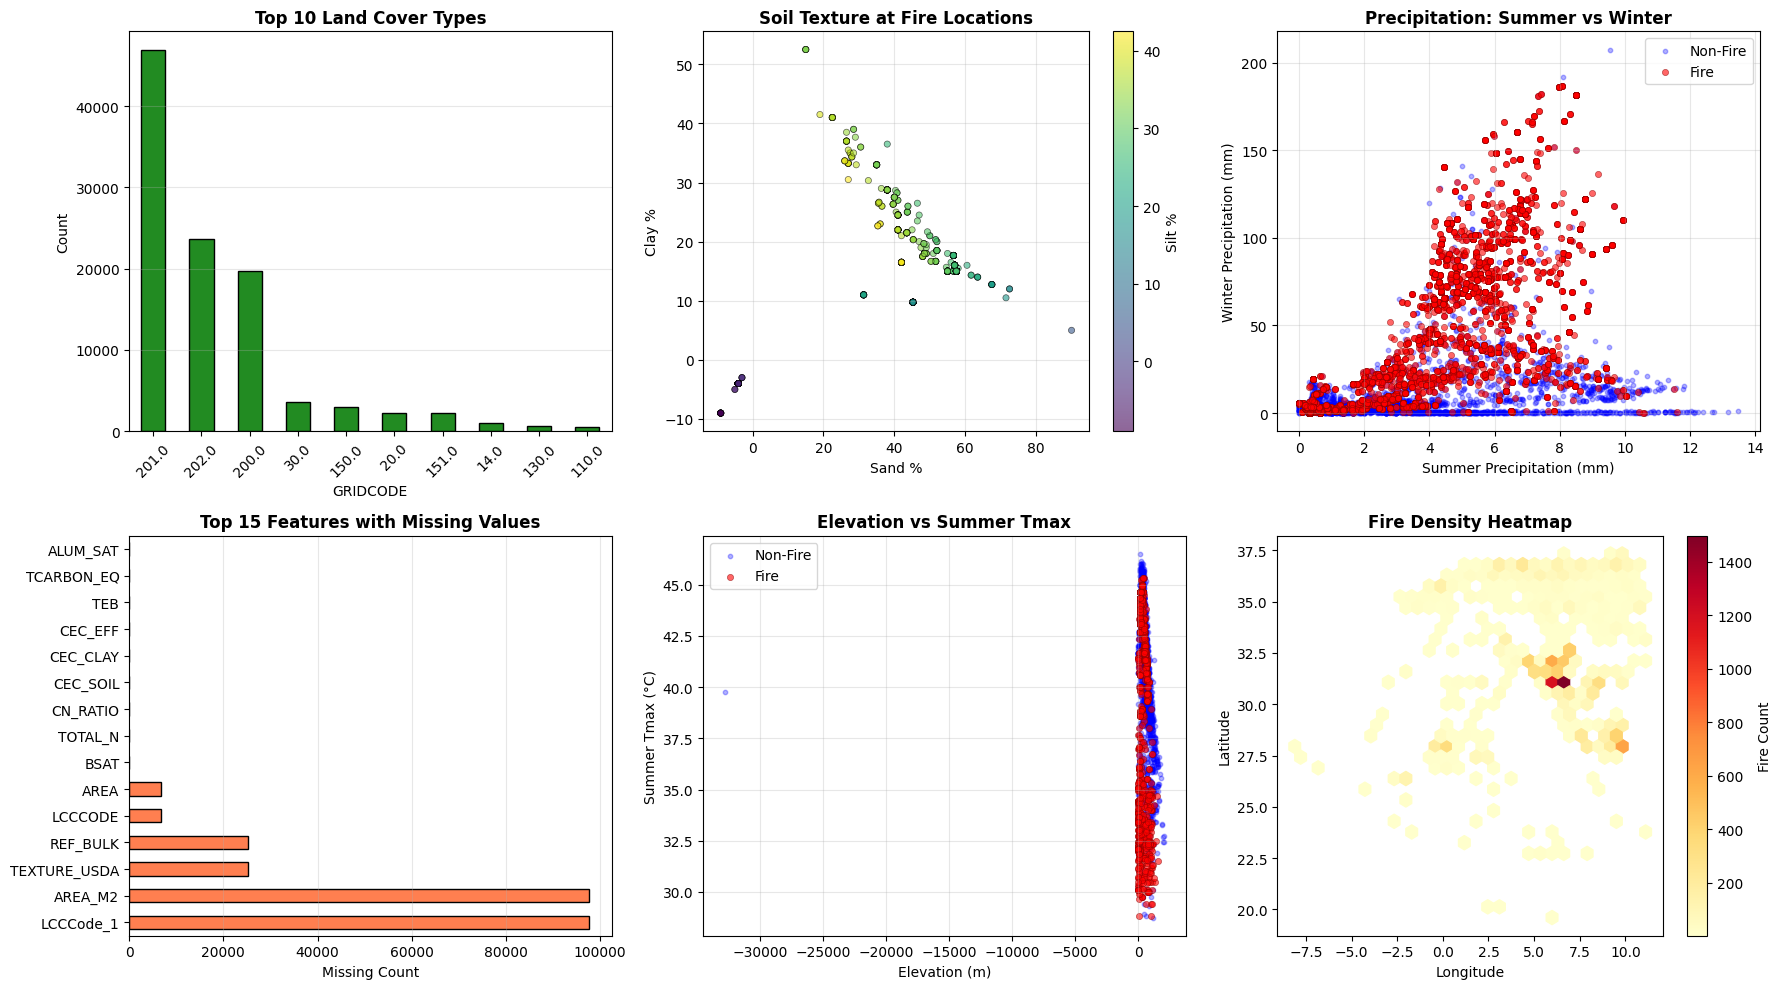

Diagnostic plots created and saved


In [18]:
def create_diagnostic_plots(df):
    """
    Create additional diagnostic visualizations.
    
    Parameters:
    -----------
    df : DataFrame
        Integrated dataset
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot 1: Land Cover Distribution
    if 'GRIDCODE' in df.columns:
        ax1 = axes[0, 0]
        df['GRIDCODE'].value_counts().head(10).plot(kind='bar', ax=ax1, color='forestgreen', edgecolor='black')
        ax1.set_title('Top 10 Land Cover Types', fontweight='bold')
        ax1.set_xlabel('GRIDCODE')
        ax1.set_ylabel('Count')
        ax1.grid(axis='y', alpha=0.3)
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Soil Texture Triangle (simplified)
    if all(c in df.columns for c in ['SAND', 'CLAY', 'SILT']):
        ax2 = axes[0, 1]
        fire_sample = df[df['fire']==1].sample(min(1000, df['fire'].sum()))
        ax2.scatter(fire_sample['SAND'], fire_sample['CLAY'], 
                   c=fire_sample['SILT'], cmap='viridis', s=20, alpha=0.6, edgecolors='black', linewidth=0.5)
        ax2.set_title('Soil Texture at Fire Locations', fontweight='bold')
        ax2.set_xlabel('Sand %')
        ax2.set_ylabel('Clay %')
        ax2.grid(True, alpha=0.3)
        plt.colorbar(ax2.collections[0], ax=ax2, label='Silt %')
    
    # Plot 3: Climate Seasonality
    if 'prec_summer' in df.columns and 'prec_winter' in df.columns:
        ax3 = axes[0, 2]
        fire_pts = df[df['fire']==1]
        nonfire_sample = df[df['fire']==0].sample(min(5000, (df['fire']==0).sum()))
        ax3.scatter(nonfire_sample['prec_summer'], nonfire_sample['prec_winter'], 
                   c='blue', alpha=0.3, s=10, label='Non-Fire')
        ax3.scatter(fire_pts['prec_summer'], fire_pts['prec_winter'], 
                   c='red', alpha=0.6, s=20, label='Fire', edgecolors='darkred', linewidth=0.5)
        ax3.set_title('Precipitation: Summer vs Winter', fontweight='bold')
        ax3.set_xlabel('Summer Precipitation (mm)')
        ax3.set_ylabel('Winter Precipitation (mm)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Missing Value Heatmap
    ax4 = axes[1, 0]
    missing_data = df.isnull().sum().sort_values(ascending=False).head(15)
    if len(missing_data) > 0:
        missing_data.plot(kind='barh', ax=ax4, color='coral', edgecolor='black')
        ax4.set_title('Top 15 Features with Missing Values', fontweight='bold')
        ax4.set_xlabel('Missing Count')
        ax4.grid(axis='x', alpha=0.3)
    
    # Plot 5: Elevation vs Temperature
    if 'elevation' in df.columns and 'tmax_summer' in df.columns:
        ax5 = axes[1, 1]
        fire_sample = df[df['fire']==1].sample(min(2000, df['fire'].sum()))
        nonfire_sample = df[df['fire']==0].sample(min(2000, (df['fire']==0).sum()))
        ax5.scatter(nonfire_sample['elevation'], nonfire_sample['tmax_summer'], 
                   c='blue', alpha=0.3, s=10, label='Non-Fire')
        ax5.scatter(fire_sample['elevation'], fire_sample['tmax_summer'], 
                   c='red', alpha=0.6, s=20, label='Fire', edgecolors='darkred', linewidth=0.5)
        ax5.set_title('Elevation vs Summer Tmax', fontweight='bold')
        ax5.set_xlabel('Elevation (m)')
        ax5.set_ylabel('Summer Tmax (°C)')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    
    # Plot 6: Fire Density Heatmap (binned)
    ax6 = axes[1, 2]
    fire_pts = df[df['fire']==1]
    ax6.hexbin(fire_pts['longitude'], fire_pts['latitude'], gridsize=30, cmap='YlOrRd', mincnt=1)
    ax6.set_title('Fire Density Heatmap', fontweight='bold')
    ax6.set_xlabel('Longitude')
    ax6.set_ylabel('Latitude')
    plt.colorbar(ax6.collections[0], ax=ax6, label='Fire Count')
    
    plt.tight_layout()
    plt.savefig('../outputs/diagnostic_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Diagnostic plots created and saved")

# Create output directory
os.makedirs('../outputs', exist_ok=True)

# Create diagnostic plots
create_diagnostic_plots(grid_df)
